In [1]:
from requests import get, post
from web3 import Web3, HTTPProvider
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import math
import json
import matplotlib.pyplot as plt


In [2]:
# Add the directory containing the module to the Python path
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

# Import functions from the module
from notebooks.uniV3Pricing import get_account_data, get_uniswap_slot0, get_nft_positions_details, get_amounts_from_ticks

In [3]:
# Explicitly specify the path to .env file using forward slashes
load_dotenv(dotenv_path='.env')

# Verify that the environment variable is loaded correctly
alchemy_key = os.getenv('ALCHEMY_KEY')

# Create the Web3 provider using the Alchemy URL
w3 = Web3(HTTPProvider(f"https://base-mainnet.g.alchemy.com/v2/{alchemy_key}")) # BASE
# w3 = Web3(HTTPProvider(f"https://eth-mainnet.g.alchemy.com/v2/{alchemy_key}")) # ETHEREUM

# Check connection
print(f"Web3 is connected: {w3.is_connected()}")


Web3 is connected: True


### GraphQL Queries

In [4]:
# Define GraphQL queries
query_accounts = """
query MyQuery {
  allAccountAssets {
    account
    numeraire
    debtUsd
    liquidationValue
    healthy
    assetDetails
    assetDetailsUsd
    collateralValue
    collateralValueUsd
    positionDistribution
    positionDistributionUsd
    usdcValue
    usedMargin
    wethValue
  }
}
"""

query_price_snap = """
query MyQuery {
  allOracleSnapshots(sortBy: "-created_at", limit: 1) {
    createdAt
    chainlinkPrices
    spotPrices
    missedAssets
  }
}"""

query_latest_snap = """
query MyQuery {
  allSnapshots(sortBy: "-created_at", limit: 1) {
    createdAt
    collateralDistribution
    collateralDistribution2
    totalCollateral
    totalCollateralUsdc
    totalCollateralWeth
    totalDebt
    totalDebtUsdc
    totalDebtWeth
    totalLiquidityUsdc
    totalLiquidityWeth
    weightedCr
    weightedCrUsdc
    weightedCrWeth
  }
}"""


### Define helper functions

In [5]:
def fetch_data(url, query):
    response = post(url, json={'query': query})
    if response.status_code == 200:
        return response.json()['data']
    else:
        raise Exception(f"Query failed to run by returning code of {response.status_code}. {query}")

def safe_json_loads(val):
    if val is None:
        return {}
    try:
        return json.loads(val.replace("'", "\""))
    except json.JSONDecodeError:
        return {}


### Fetch Data

In [6]:
url = "https://data-core.up.railway.app/protocols/arcadia/graphql/"

# Fetch account data
account_data = fetch_data(url, query_accounts)['allAccountAssets']

# Fetch price snapshot data
price_snap_data = fetch_data(url, query_price_snap)['allOracleSnapshots'][0]

# Fetch latest snapshot data
latest_snap_data = fetch_data(url, query_latest_snap)['allSnapshots'][0]


### Process Price Snapshot Data

In [7]:
# Convert JSON strings to dictionaries
chainlink_prices = json.loads(price_snap_data['chainlinkPrices'])
spot_prices = json.loads(price_snap_data['spotPrices'])
missed_assets = json.loads(price_snap_data['missedAssets'])

# Convert dictionaries to DataFrames
df_chainlink_prices = pd.DataFrame.from_dict(chainlink_prices, orient='index')
df_spot_prices = pd.DataFrame.from_dict(spot_prices, orient='index')
df_missed_assets = pd.DataFrame(missed_assets)

# Display the DataFrames
print("Chainlink Prices:")
print(df_chainlink_prices)

print("\nSpot Prices:")
print(df_spot_prices)

print("\nMissed Assets:")
print(df_missed_assets)


Chainlink Prices:
                                                                       name  \
0x2ae3f1ec7f1f5012cfeab0185bfc7aa3cf0dec22      Coinbase Wrapped Staked ETH   
0x4200000000000000000000000000000000000006                    Wrapped Ether   
0x833589fcd6edb6e08f4c7c32d4f71b54bda02913                         USD Coin   
0x940181a94a35a4569e4529a3cdfb74e38fd98631                        Aerodrome   
0xb6fe221fe9eef5aba221c348ba20a1bf5e73624c                  Rocket Pool ETH   
0xc1cba3fcea344f92d9239c08c0568f6f2f0ee452  Wrapped liquid staked Ether 2.0   
0xd9aaec86b65d86f6a7b5b1b0c42ffa531710b6ca                    USD Base Coin   

                                                  price  symbol  
0x2ae3f1ec7f1f5012cfeab0185bfc7aa3cf0dec22  3649.520000   cbETH  
0x4200000000000000000000000000000000000006  3389.270000    WETH  
0x833589fcd6edb6e08f4c7c32d4f71b54bda02913     0.999990    USDC  
0x940181a94a35a4569e4529a3cdfb74e38fd98631     0.910028    AERO  
0xb6fe221fe9eef5aba

### Process Latest Protocol Snapshot Data

In [8]:
# Convert JSON strings to dictionaries
collateral_distribution = json.loads(latest_snap_data['collateralDistribution'])
collateral_distribution2 = json.loads(latest_snap_data['collateralDistribution2'])

# Convert dictionaries to DataFrames
df_collateral_distribution = pd.DataFrame(list(collateral_distribution.items()), columns=['Asset', 'Value'])
df_collateral_distribution2 = pd.DataFrame(list(collateral_distribution2.items()), columns=['Asset', 'Value'])

# Display the DataFrames
print("Collateral Distribution:")
print(df_collateral_distribution)

print("\nCollateral Distribution 2:")
print(df_collateral_distribution2)


Collateral Distribution:
                                        Asset          Value
0                                         NFT  863347.717149
1  0x2Ae3F1Ec7F1F5012CFEab0185bfc7aa3cf0DEc22    1076.954325
2  0x4200000000000000000000000000000000000006   19038.971294
3  0x50c5725949A6F0c72E6C4a641F24049A917DB0Cb      10.018428
4  0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913   13929.628064
5  0x940181a94A35A4569E4529A3CDfB74e38FD98631     367.659388
6  0xB6fe221Fe9EeF5aBa221c348bA20A1Bf5e73624c     649.155062
7  0xc1CBa3fCea344f92D9239c08C0568f6F2F0ee452    1012.754576
8  0xd9aAEc86B65D86f6A7B5B1b0c42FFA531710b6CA    2412.336928

Collateral Distribution 2:
                                        Asset          Value
0                                      others   46393.704178
1  0x2Ae3F1Ec7F1F5012CFEab0185bfc7aa3cf0DEc22    1078.629498
2  0x4200000000000000000000000000000000000006  398933.545572
3  0x50c5725949A6F0c72E6C4a641F24049A917DB0Cb    3377.385813
4  0x833589fCD6eDb6E08f4c7C32D4f

### Process Account Data

In [9]:
# Convert JSON data to a DataFrame
accounts_df = pd.DataFrame(account_data)

# Parse nested JSON fields
accounts_df['assetDetails'] = accounts_df['assetDetails'].apply(safe_json_loads)
accounts_df['assetDetailsUsd'] = accounts_df['assetDetailsUsd'].apply(safe_json_loads)
accounts_df['positionDistribution'] = accounts_df['positionDistribution'].apply(safe_json_loads)
accounts_df['positionDistributionUsd'] = accounts_df['positionDistributionUsd'].apply(safe_json_loads)

# Ensure 'debtUsd' is treated as a float and filter for non-zero debtUsd
accounts_df['debtUsd'] = accounts_df['debtUsd'].astype(float)
debtUsd_df = accounts_df[accounts_df['debtUsd'] > 0]

# Display DataFrame
print("Accounts Data:")
print(debtUsd_df.head())


Accounts Data:
                                       account  \
1   0x26ae412c72623e8b6806aaf451c20c06a1e897fb   
6   0x362c2044c649ed82f68f7248ea653c0474f728ea   
8   0x3134f100cfee2b243a4e720a10fd072295c35c2b   
11  0x6acb57166f732c4e62380a60cfd1a5631eb88e83   
12  0x9c0b5e995264bed11bea54642fb6c1e7dd4855cb   

                                     numeraire       debtUsd  \
1   0x4200000000000000000000000000000000000006    858.452104   
6   0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913  18594.314296   
8   0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913   2021.036170   
11  0x4200000000000000000000000000000000000006  24778.723374   
12  0x4200000000000000000000000000000000000006   3245.048856   

       liquidationValue healthy  \
1    319373800190396436    True   
6           20411022406    True   
8            2292339815    True   
11  7431651026777022202   False   
12  1769448781932142467    True   

                                         assetDetails  \
1   [[0x42000000000000000000000

In [35]:
# Search for the specific account in the 'account' column
specific_account_df = accounts_df[accounts_df['account'] == '0x220b256a249076bc619669bed16621106883ef90']

# Display the row
print("Details for account 0x220b256a249076bc619669bed16621106883ef90:")
print(specific_account_df.to_string(index=False))

# Search for the specific account in the 'account' column
specific_account_df = accounts_df[accounts_df['account'] == '0x220b256a249076bc619669bed16621106883ef90']

# Get the value in the 'positionDistributionUsd' column
position_distribution_usd = specific_account_df['positionDistribution'].values[0]

# Print the value
print("Details for account 0x220b256a249076bc619669bed16621106883ef90:")
print(position_distribution_usd)

Details for account 0x220b256a249076bc619669bed16621106883ef90:
                                   account                                  numeraire      debtUsd liquidationValue healthy                                                                                                                                                                                                                                                                                              assetDetails                                                                                                                                                                                                                  assetDetailsUsd collateralValue collateralValueUsd                                                                                                                                                                  positionDistribution                                                                         

## Metric Cards Overview

### Part 1

In [11]:
# Calculate metrics
metric_active_accounts = debtUsd_df['account'].nunique()
metric_total_debt_usd = debtUsd_df['debtUsd'].sum()

# Ensure 'collateralValueUsd' is treated as a float
debtUsd_df.loc[:, 'collateralValueUsd'] = debtUsd_df['collateralValueUsd'].astype(float)
metric_total_collateral_usd = debtUsd_df['collateralValueUsd'].sum()

# Calculate total pool supply in USD
total_liquidity_usdc = float(latest_snap_data['totalLiquidityUsdc'])
total_liquidity_weth = float(latest_snap_data['totalLiquidityWeth'])
metric_USDC_supply = total_liquidity_usdc * df_chainlink_prices.loc['0x833589fcd6edb6e08f4c7c32d4f71b54bda02913', 'price']
metric_WETH_supply = total_liquidity_weth * df_chainlink_prices.loc['0x4200000000000000000000000000000000000006', 'price']
metric_total_supply_usd = metric_USDC_supply + metric_WETH_supply

# Calculate weighted collateral ratio
metric_weighted_cr = float(latest_snap_data['weightedCr'])

# Calculate additional metrics
total_debt = float(latest_snap_data['totalDebt'])
total_debt_usdc = float(latest_snap_data['totalDebtUsdc'])
total_debt_weth = float(latest_snap_data['totalDebtWeth'])

util_usdc = total_debt_usdc / metric_USDC_supply
util_weth = total_debt_weth / metric_WETH_supply

metric_weighted_utilization = ((util_usdc * total_debt_usdc) + (util_weth * total_debt_weth)) / total_debt

print(f"Number of active accounts with debtUsd > 0: {metric_active_accounts}")
print(f"Total debtUsd with debtUsd > 0: $ {metric_total_debt_usd}")
print(f"Total collateralValueUsd with debtUsd > 0: $ {metric_total_collateral_usd}")
print(f"Total pool supply with debtUsd > 0: $ {metric_total_supply_usd}")
print(f"Weighted CR: {metric_weighted_cr}")
print(f"Weighted utilization: {metric_weighted_utilization}")


Number of active accounts with debtUsd > 0: 141
Total debtUsd with debtUsd > 0: $ 611493.8837764997
Total collateralValueUsd with debtUsd > 0: $ 836762.2770779997
Total pool supply with debtUsd > 0: $ 1407422.4998259712
Weighted CR: 0.677511044954139
Weighted utilization: 0.45970000193855004


### Part 2

In [12]:
# Normalize 'healthy' column and filter for 'false'
debtUsd_df.loc[:, 'healthy_normalized'] = debtUsd_df['healthy'].astype(str).str.lower()
unhealthy_df = debtUsd_df[debtUsd_df['healthy_normalized'] == 'false']

metric_unhealthy_active_accounts = unhealthy_df['account'].nunique()
metric_total_unhealthy_debt_usd = unhealthy_df['debtUsd'].sum()

# Convert 'usedMargin' and 'liquidationValue' to numeric values
debtUsd_df.loc[:, 'usedMargin'] = pd.to_numeric(debtUsd_df['usedMargin'], errors='coerce')
debtUsd_df.loc[:, 'liquidationValue'] = pd.to_numeric(debtUsd_df['liquidationValue'], errors='coerce')

# Filter for accounts where 'usedMargin' is greater than 'liquidationValue'
liquidatable_accounts_df = debtUsd_df[debtUsd_df['usedMargin'] > debtUsd_df['liquidationValue']]
metric_liquidatable_active_accounts = liquidatable_accounts_df['account'].nunique()
metric_total_liquidatable_debt_usd = liquidatable_accounts_df['debtUsd'].sum()

print(f"Number of unhealthy active accounts with debtUsd > 0: {metric_unhealthy_active_accounts}")
print(f"Total unhealthy debtUsd with debtUsd > 0: $ {metric_total_unhealthy_debt_usd}")
print(f"Number of liquidatable active accounts with debtUsd > 0: {metric_liquidatable_active_accounts}")
print(f"Total liquidatable debtUsd with debtUsd > 0: $ {metric_total_liquidatable_debt_usd}")


Number of unhealthy active accounts with debtUsd > 0: 24
Total unhealthy debtUsd with debtUsd > 0: $ 150850.25619522357
Number of liquidatable active accounts with debtUsd > 0: 0
Total liquidatable debtUsd with debtUsd > 0: $ 0.0


C:\Users\dhruv\AppData\Local\Temp\ipykernel_14640\1665336732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debtUsd_df.loc[:, 'healthy_normalized'] = debtUsd_df['healthy'].astype(str).str.lower()


### Part 3

In [13]:
# Calculate 5% of active accounts and use ceiling function
metric_top_active_accounts = math.ceil(metric_active_accounts * 0.05)

# Sort the DataFrame by 'debtUsd' in decreasing order and select top accounts
sorted_debtUsd_df = debtUsd_df.sort_values(by='debtUsd', ascending=False)
top_accounts_df = sorted_debtUsd_df.head(metric_top_active_accounts)

# Calculate the sum of 'debtUsd' for the top accounts
metric_top_active_accounts_debt_usd = top_accounts_df['debtUsd'].sum()

print(f"Number of top active accounts (5% of active accounts): {metric_top_active_accounts}")
print(f"Total debtUsd for the top active accounts (5% of active accounts): $ {metric_top_active_accounts_debt_usd}")


Number of top active accounts (5% of active accounts): 8
Total debtUsd for the top active accounts (5% of active accounts): $ 368136.2789664309


## Asset: USDC

In [14]:
# Calculate Chainlink and Spot prices for USDC
metric_USDC_oracle_price = df_chainlink_prices.loc['0x833589fcd6edb6e08f4c7c32d4f71b54bda02913', 'price']
print(f"Chainlink price of USDC: {metric_USDC_oracle_price}")

metric_USDC_spot_price = df_spot_prices.loc['0x833589fcd6edb6e08f4c7c32d4f71b54bda02913', 'price']
print(f"Spot price of USDC: {metric_USDC_spot_price}")

metric_USDC_deviation = abs(metric_USDC_oracle_price - metric_USDC_spot_price) * 100 / metric_USDC_oracle_price
print(f"Deviation from spot price USDC: {metric_USDC_deviation} %")

# Normalize 'numeraire' to lowercase and filter for USDC numeraire
debtUsd_df.loc[:, 'numeraire_normalized'] = debtUsd_df['numeraire'].str.lower()
debtUsd_USDC = debtUsd_df[debtUsd_df['numeraire_normalized'] == '0x833589fcd6edb6e08f4c7c32d4f71b54bda02913']

# Calculate metrics for USDC numeraire
metric_USDC_active_accounts = debtUsd_USDC['account'].nunique()
metric_USDC_total_debt_usd = debtUsd_USDC['debtUsd'].sum()

# Normalize 'healthy' column and filter for 'false'
debtUsd_USDC.loc[:, 'healthy_normalized'] = debtUsd_USDC['healthy'].astype(str).str.lower()
unhealthy_USDC_df = debtUsd_USDC[debtUsd_USDC['healthy_normalized'] == 'false']

metric_USDC_unhealthy_active_accounts = unhealthy_USDC_df['account'].nunique()
metric_USDC_total_unhealthy_debt_usd = unhealthy_USDC_df['debtUsd'].sum()

# Convert 'usedMargin' and 'liquidationValue' to numeric values
debtUsd_USDC.loc[:, 'usedMargin'] = pd.to_numeric(debtUsd_USDC['usedMargin'], errors='coerce')
debtUsd_USDC.loc[:, 'liquidationValue'] = pd.to_numeric(debtUsd_USDC['liquidationValue'], errors='coerce')

# Filter for accounts where 'usedMargin' is greater than 'liquidationValue'
liquidatable_USDC_df = debtUsd_USDC[debtUsd_USDC['usedMargin'] > debtUsd_USDC['liquidationValue']]
metric_USDC_liquidatable_active_accounts = liquidatable_USDC_df['account'].nunique()
metric_USDC_total_liquidatable_debt_usd = liquidatable_USDC_df['debtUsd'].sum()

# Display the metrics
print(f"Number of active accounts with debtUsd > 0 (USDC): {metric_USDC_active_accounts}")
print(f"Total debtUsd with debtUsd > 0 (USDC): $ {metric_USDC_total_debt_usd}")
print(f"Number of unhealthy active accounts with debtUsd > 0 (USDC): {metric_USDC_unhealthy_active_accounts}")
print(f"Total unhealthy debtUsd with debtUsd > 0 (USDC): $ {metric_USDC_total_unhealthy_debt_usd}")
print(f"Number of liquidatable active accounts with debtUsd > 0 (USDC): {metric_USDC_liquidatable_active_accounts}")
print(f"Total liquidatable debtUsd with debtUsd > 0 (USDC): $ {metric_USDC_total_liquidatable_debt_usd}")

print(f"Total Supply USDC: $ {metric_USDC_supply}")
print(f"Total Debt USDC: $ {total_debt_usdc}")

metric_USDC_collateral = float(latest_snap_data['totalCollateralUsdc'])
print(f"Total Collateral USDC: $ {metric_USDC_collateral}")

metric_utilization_USDC = util_usdc*100
print(f"Utilization USDC: {metric_utilization_USDC} %")

Chainlink price of USDC: 0.99999
Spot price of USDC: 0.999895
Deviation from spot price USDC: 0.009500095000956735 %
Number of active accounts with debtUsd > 0 (USDC): 71
Total debtUsd with debtUsd > 0 (USDC): $ 367613.14020100003
Number of unhealthy active accounts with debtUsd > 0 (USDC): 9
Total unhealthy debtUsd with debtUsd > 0 (USDC): $ 11859.648773
Number of liquidatable active accounts with debtUsd > 0 (USDC): 0
Total liquidatable debtUsd with debtUsd > 0 (USDC): $ 0.0
Total Supply USDC: $ 676121.7115952712
Total Debt USDC: $ 367607.84109
Total Collateral USDC: $ 558673.175796
Utilization USDC: 54.37006899580993 %


C:\Users\dhruv\AppData\Local\Temp\ipykernel_14640\929547440.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debtUsd_df.loc[:, 'numeraire_normalized'] = debtUsd_df['numeraire'].str.lower()


## Asset: ETH

In [15]:
# Calculate Chainlink and Spot prices for ETH
metric_ETH_oracle_price = df_chainlink_prices.loc['0x4200000000000000000000000000000000000006', 'price']
print(f"Chainlink price of ETH: {metric_ETH_oracle_price}")

metric_ETH_spot_price = df_spot_prices.loc['0x4200000000000000000000000000000000000006', 'price']
print(f"Spot price of ETH: {metric_ETH_spot_price}")

metric_ETH_deviation = abs(metric_ETH_oracle_price - metric_ETH_spot_price) * 100 / metric_ETH_oracle_price
print(f"Deviation from spot price ETH: {metric_ETH_deviation} %")

# Normalize 'numeraire' to lowercase and filter for ETH numeraire
debtUsd_df.loc[:, 'numeraire_normalized'] = debtUsd_df['numeraire'].str.lower()
debtUsd_ETH = debtUsd_df[debtUsd_df['numeraire_normalized'] == '0x4200000000000000000000000000000000000006']

# Calculate metrics for ETH numeraire
metric_ETH_active_accounts = debtUsd_ETH['account'].nunique()
metric_ETH_total_debt_usd = debtUsd_ETH['debtUsd'].sum()

# Normalize 'healthy' column and filter for 'false'
debtUsd_ETH.loc[:, 'healthy_normalized'] = debtUsd_ETH['healthy'].astype(str).str.lower()
unhealthy_ETH_df = debtUsd_ETH[debtUsd_ETH['healthy_normalized'] == 'false']

metric_ETH_unhealthy_active_accounts = unhealthy_ETH_df['account'].nunique()
metric_ETH_total_unhealthy_debt_usd = unhealthy_ETH_df['debtUsd'].sum()

# Convert 'usedMargin' and 'liquidationValue' to numeric values
debtUsd_ETH.loc[:, 'usedMargin'] = pd.to_numeric(debtUsd_ETH['usedMargin'], errors='coerce')
debtUsd_ETH.loc[:, 'liquidationValue'] = pd.to_numeric(debtUsd_ETH['liquidationValue'], errors='coerce')

# Filter for accounts where 'usedMargin' is greater than 'liquidationValue'
liquidatable_ETH_df = debtUsd_ETH[debtUsd_ETH['usedMargin'] > debtUsd_ETH['liquidationValue']]
metric_ETH_liquidatable_active_accounts = liquidatable_ETH_df['account'].nunique()
metric_ETH_total_liquidatable_debt_usd = liquidatable_ETH_df['debtUsd'].sum()

# Display the metrics
print(f"Number of active accounts with debtUsd > 0 (ETH): {metric_ETH_active_accounts}")
print(f"Total debtUsd with debtUsd > 0 (ETH): $ {metric_ETH_total_debt_usd}")
print(f"Number of unhealthy active accounts with debtUsd > 0 (ETH): {metric_ETH_unhealthy_active_accounts}")
print(f"Total unhealthy debtUsd with debtUsd > 0 (ETH): $ {metric_ETH_total_unhealthy_debt_usd}")
print(f"Number of liquidatable active accounts with debtUsd > 0 (ETH): {metric_ETH_liquidatable_active_accounts}")
print(f"Total liquidatable debtUsd with debtUsd > 0 (ETH): $ {metric_ETH_total_liquidatable_debt_usd}")

print(f"Total Supply ETH: $ {metric_WETH_supply}")
print(f"Total Debt ETH: $ {total_debt_weth}")

metric_ETH_collateral = float(latest_snap_data['totalCollateralWeth'])
print(f"Total Collateral ETH: $ {metric_ETH_collateral}")

metric_utilization_ETH = util_weth * 100

print(f"Utilization ETH: {metric_utilization_ETH} %")


Chainlink price of ETH: 3389.27
Spot price of ETH: 3390.21
Deviation from spot price ETH: 0.027734585913782455 %
Number of active accounts with debtUsd > 0 (ETH): 70
Total debtUsd with debtUsd > 0 (ETH): $ 243880.7435754995
Number of unhealthy active accounts with debtUsd > 0 (ETH): 15
Total unhealthy debtUsd with debtUsd > 0 (ETH): $ 138990.60742222355
Number of liquidatable active accounts with debtUsd > 0 (ETH): 0
Total liquidatable debtUsd with debtUsd > 0 (ETH): $ 0.0
Total Supply ETH: $ 731300.7882307
Total Debt ETH: $ 243402.239505629
Total Collateral ETH: $ 343172.019417
Utilization ETH: 33.283464673204215 %


## Liquidation Potential ETH

In [16]:
import requests

# Fetch risk parameters without headers
risk_params_url = "https://data-core.up.railway.app/protocols/arcadia/get_risk_params/"
risk_params_response = requests.get(risk_params_url)
if risk_params_response.status_code == 200:
    risk_params_data = risk_params_response.json()
else:
    raise Exception(f"Risk parameters query failed with status code {risk_params_response.status_code}")

# Set liquidation factors
liquidation_factors = {item['contract_address']: item['risk_params']['liquidation_factor'] for item in risk_params_data}


In [17]:
# import pandas as pd

# Set asset decimals
asset_decimals = {
    '0x2ae3f1ec7f1f5012cfeab0185bfc7aa3cf0dec22': 18,
    '0x4200000000000000000000000000000000000006': 18,
    '0x833589fcd6edb6e08f4c7c32d4f71b54bda02913': 6,
    '0xd9aaec86b65d86f6a7b5b1b0c42ffa531710b6ca': 6,
    '0xc1cba3fcea344f92d9239c08c0568f6f2f0ee452': 18,
    '0x940181a94a35a4569e4529a3cdfb74e38fd98631': 18,
    '0x50c5725949a6f0c72e6c4a641f24049a917db0cb': 18,
    '0xb6fe221fe9eef5aba221c348ba20a1bf5e73624c': 18,
}

# # Display asset options
# print("Available assets:")
# for asset in asset_decimals.keys():
#     print(asset)

# # User input for asset selection
# selected_asset = input("Please enter the contract address of the asset you want to adjust: ").lower()

# # Check if the asset is valid
# if selected_asset not in asset_decimals:
#     raise ValueError("Invalid asset contract address.")

# # User input for price direction
# price_direction = input("Do you want to increase or decrease the price? (Enter 'increase' or 'decrease'): ").lower()
# if price_direction not in ['increase', 'decrease']:
#     raise ValueError("Invalid direction. Please enter 'increase' or 'decrease'.")

# # User input for price adjustment percentage
# price_change_percent = float(input("By what percentage should the price change? (Enter a positive number): "))
# if price_change_percent < 0:
#     raise ValueError("Percentage should be a positive number.")

# # Calculate the new price
# current_price = df_chainlink_prices.loc[selected_asset, 'price']
# if price_direction == 'increase':
#     new_price = current_price * (1 + price_change_percent / 100)
# else:
#     new_price = current_price * (1 - price_change_percent / 100)

# print(f"The new price for the asset {selected_asset} is: {new_price}")


In [43]:
# dump

# Search for the specific account in the 'account' column
specific_account_df_debt = debtUsd_df[debtUsd_df['account'] == '0x220b256a249076bc619669bed16621106883ef90']

# Display the row
print("Details for account 0x220b256a249076bc619669bed16621106883ef90:")
print(specific_account_df_debt.to_string(index=False))

from sympy import symbols, Eq, solve

# Define the unknown variable for ETH price
eth_price_symbol = symbols('eth_price')

# Initialize a DataFrame to store the results
results = []

# Iterate over each account in debtUsd_df
for index, row in specific_account_df_debt.iterrows():
    numeraire = row['numeraire_normalized'].lower()
    ic(numeraire)
    used_margin = row['usedMargin']
    ic(used_margin)
    position_distribution = {k.lower(): v for k, v in row['positionDistribution'].items()}
    position_distribution_usd_others = row['positionDistributionUsd'].get('others', 0)
    collateral_value_usd_past = row['collateralValueUsd']

    # Determine the decimal for the numeraire
    numeraire_decimals = asset_decimals.get(numeraire, 18)
    ic(numeraire_decimals)

    # Calculate the left-hand side of the equation
    if numeraire == '0x4200000000000000000000000000000000000006':  # If numeraire is ETH
        lhs = used_margin * eth_price_symbol / (10 ** numeraire_decimals)
        ic(lhs)
    else:
        numeraire_price = df_chainlink_prices.loc[numeraire, 'price'] if numeraire in df_chainlink_prices.index else 0
        lhs = used_margin * numeraire_price / (10 ** numeraire_decimals)
        ic(lhs)

    # Calculate the right-hand side of the equation
    rhs = position_distribution_usd_others
    ic(rhs)
    for asset, amount in position_distribution.items():
        ic(asset)
        liquidation_factor = liquidation_factors.get(asset, 1)
        decimals = asset_decimals.get(asset, 18)
        if asset == '0x4200000000000000000000000000000000000006':  # If asset is ETH
            rhs += (amount * liquidation_factor * eth_price_symbol) / (10 ** decimals)
            ic(amount)
            ic(liquidation_factor)
            ic(asset_price)
            ic(rhs)
        else:
            asset_price = df_chainlink_prices.loc[asset, 'price'] if asset in df_chainlink_prices.index else 0
            rhs += (amount * liquidation_factor * asset_price) / (10 ** decimals)
            ic(amount)
            ic(liquidation_factor)
            ic(asset_price)
            ic((amount * liquidation_factor * asset_price) / (10 ** decimals))
            ic(rhs)

    # Solve the equation lhs = rhs for eth_price_symbol
    equation = Eq(lhs, rhs)
    eth_price_solution = solve(equation, eth_price_symbol)
    ic(eth_price_solution)

    # Store the result if a valid solution is found
    if eth_price_solution:
        eth_price = eth_price_solution[0]

        # Calculate affected collateral using the found ETH price
        affected_collateral = position_distribution_usd_others
        for asset, amount in position_distribution.items():
            liquidation_factor = liquidation_factors.get(asset, 1)
            decimals = asset_decimals.get(asset, 18)
            if asset == '0x4200000000000000000000000000000000000006':  # If asset is ETH
                affected_collateral += (amount * liquidation_factor * eth_price) / (10 ** decimals)
            else:
                asset_price = df_chainlink_prices.loc[asset, 'price'] if asset in df_chainlink_prices.index else 0
                affected_collateral += (amount * liquidation_factor * asset_price) / (10 ** decimals)

        results.append({
            'Account': row['account'],
            'Numeraire': numeraire,
            'Affected Collateral': affected_collateral,
            'Affected Collateral Past': collateral_value_usd_past,
            'ETH Price': eth_price
        })

# Convert the results to a DataFrame
results_df_dump = pd.DataFrame(results)

# Display the results
# print(results_df_dump)



ic| numeraire: '0x833589fcd6edb6e08f4c7c32d4f71b54bda02913'
ic| used_margin: 13992519226
ic| numeraire_decimals: 6
ic| lhs: np.float64(13992.379300807741)
ic| rhs: 343.37000951837035
ic| asset: '0x4200000000000000000000000000000000000006'
ic| amount: 5317246457497226723
ic| liquidation_factor: 0.85
ic| asset_price: np.float64(0.99999)
ic| rhs: 4.51965948887264*eth_price + 343.37000951837
ic| asset: '0x833589fcd6edb6e08f4c7c32d4f71b54bda02913'
ic| amount: 1415497564
ic| liquidation_factor: 0.94
ic| asset_price: np.float64(0.99999)
ic| (amount * liquidation_factor * asset_price) / (10 ** decimals): np.float64(1330.5544044828982)
ic| rhs: 4.51965948887264*eth_price + 1673.92441400127
ic| asset: '0xd9aaec86b65d86f6a7b5b1b0c42ffa531710b6ca'
ic| amount: 23277821
ic| liquidation_factor: 0.94
ic| asset_price: np.float64(0.99999)
ic| (amount * liquidation_factor * asset_price) / (10 ** decimals): np.float64(21.8809329284826)
ic| rhs: 4.51965948887264*eth_price + 1695.80534692975
ic| eth_price_s

In [18]:
from sympy import symbols, Eq, solve

# Define the unknown variable for ETH price
eth_price_symbol = symbols('eth_price')

# Initialize a DataFrame to store the results
results = []

# Iterate over each account in debtUsd_df
for index, row in debtUsd_df.iterrows():
    numeraire = row['numeraire_normalized'].lower()
    used_margin = row['usedMargin']
    position_distribution = {k.lower(): v for k, v in row['positionDistribution'].items()}
    position_distribution_usd_others = row['positionDistributionUsd'].get('others', 0)
    collateral_value_usd_past = row['collateralValueUsd']

    # Determine the decimal for the numeraire
    numeraire_decimals = asset_decimals.get(numeraire, 18)

    # Calculate the left-hand side of the equation
    if numeraire == '0x4200000000000000000000000000000000000006':  # If numeraire is ETH
        lhs = used_margin * eth_price_symbol / (10 ** numeraire_decimals)
    else:
        numeraire_price = df_chainlink_prices.loc[numeraire, 'price'] if numeraire in df_chainlink_prices.index else 0
        lhs = used_margin * numeraire_price / (10 ** numeraire_decimals)

    # Calculate the right-hand side of the equation
    rhs = position_distribution_usd_others
    for asset, amount in position_distribution.items():
        liquidation_factor = liquidation_factors.get(asset, 1)
        decimals = asset_decimals.get(asset, 18)
        if asset == '0x4200000000000000000000000000000000000006':  # If asset is ETH
            rhs += (amount * liquidation_factor * eth_price_symbol) / (10 ** decimals)
        else:
            asset_price = df_chainlink_prices.loc[asset, 'price'] if asset in df_chainlink_prices.index else 0
            rhs += (amount * liquidation_factor * asset_price) / (10 ** decimals)

    # Solve the equation lhs = rhs for eth_price_symbol
    equation = Eq(lhs, rhs)
    eth_price_solution = solve(equation, eth_price_symbol)

    # Store the result if a valid solution is found
    if eth_price_solution:
        eth_price = eth_price_solution[0]

        # Calculate affected collateral using the found ETH price
        affected_collateral = position_distribution_usd_others
        for asset, amount in position_distribution.items():
            liquidation_factor = liquidation_factors.get(asset, 1)
            decimals = asset_decimals.get(asset, 18)
            if asset == '0x4200000000000000000000000000000000000006':  # If asset is ETH
                affected_collateral += (amount * liquidation_factor * eth_price) / (10 ** decimals)
            else:
                asset_price = df_chainlink_prices.loc[asset, 'price'] if asset in df_chainlink_prices.index else 0
                affected_collateral += (amount * liquidation_factor * asset_price) / (10 ** decimals)

        results.append({
            'Account': row['account'],
            'Numeraire': numeraire,
            'Affected Collateral': affected_collateral,
            'Affected Collateral Past': collateral_value_usd_past,
            'ETH Price': eth_price
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)



                                        Account  \
0    0x26ae412c72623e8b6806aaf451c20c06a1e897fb   
1    0x362c2044c649ed82f68f7248ea653c0474f728ea   
2    0x3134f100cfee2b243a4e720a10fd072295c35c2b   
3    0x6acb57166f732c4e62380a60cfd1a5631eb88e83   
4    0x9c0b5e995264bed11bea54642fb6c1e7dd4855cb   
..                                          ...   
123  0x7352aa33e15e3580b1f77b6dcaf05dd7df7f888e   
124  0x8e0937e6ff9c261d47947dfbffc845e03d9b6c8b   
125  0xe13e62c831d0149eb44415a0de75fbaf309a84a3   
126  0xbcb536082805d1f7a28a2a103535f44761f60767   
127  0xbf7d83fc7109fdb12c17bf7aa49fb8bf345953ca   

                                      Numeraire Affected Collateral  \
0    0x4200000000000000000000000000000000000006   -49.1943123703937   
1    0x833589fcd6edb6e08f4c7c32d4f71b54bda02913    18596.1283328570   
2    0x833589fcd6edb6e08f4c7c32d4f71b54bda02913    2023.01592363846   
3    0x4200000000000000000000000000000000000006    2183.30330969380   
4    0x4200000000000000000000000

In [25]:
# sorth the results_df by ETH Price
results_df = results_df.sort_values(by='ETH Price')


# export the results_df to a csv file
results_df.to_csv('results.csv', index=False)

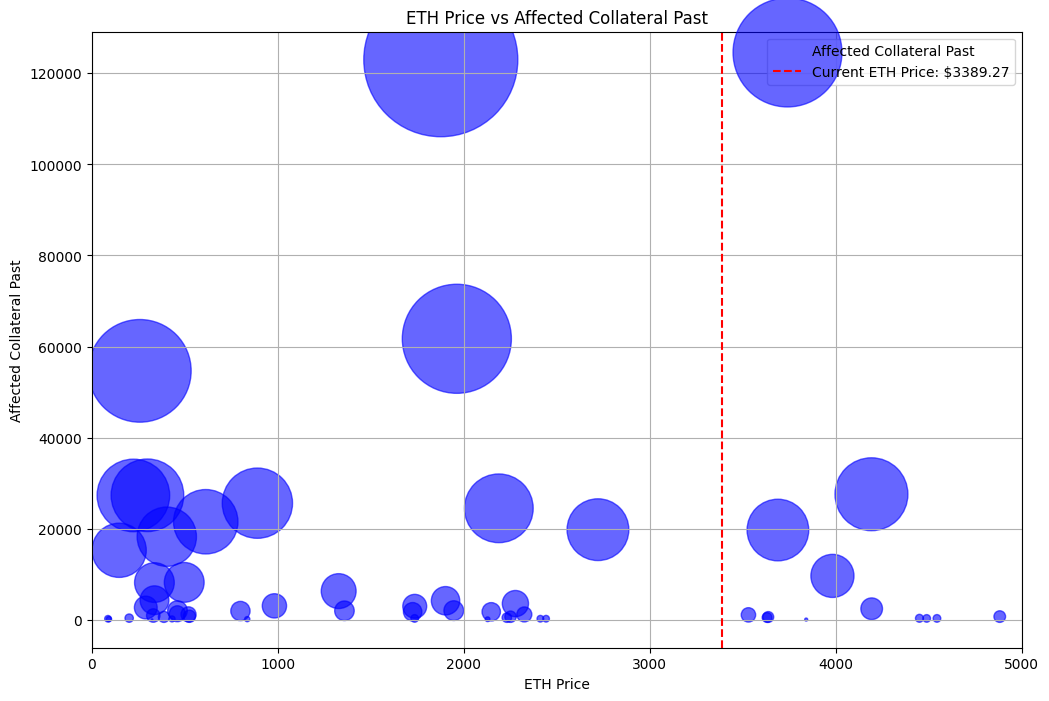

In [19]:
import matplotlib.pyplot as plt

# Filter the results DataFrame to only include rows where ETH Price is between 0 and 5000
results_df_filtered = results_df[(results_df['ETH Price'] > 0) & (results_df['ETH Price'] <= 5000)]

# Sort the filtered DataFrame by ETH Price
results_df_sorted = results_df_filtered.sort_values(by='ETH Price')

# Plot ETH Price vs Affected Collateral Past as a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(results_df_sorted['ETH Price'], results_df_sorted['Affected Collateral Past'], 
            s=results_df_sorted['Affected Collateral Past'] / 10,  # Adjust size scaling as needed
            label='Affected Collateral Past', color='blue', alpha=0.6)

# Point the current ETH price on the chart
current_eth_price = df_chainlink_prices.loc['0x4200000000000000000000000000000000000006', 'price']
plt.axvline(x=current_eth_price, color='red', linestyle='--', label=f'Current ETH Price: ${current_eth_price:.2f}')

plt.xlabel('ETH Price')
plt.ylabel('Affected Collateral Past')
plt.title('ETH Price vs Affected Collateral Past')
plt.legend(loc='upper right')  # Adjust legend location
plt.grid(True)
plt.xlim(0, 5000)  # Set the x-axis limit to display the range between 0 and 5000
plt.show()


Unique Numeraires in the filtered data: ['0x4200000000000000000000000000000000000006'
 '0x833589fcd6edb6e08f4c7c32d4f71b54bda02913']


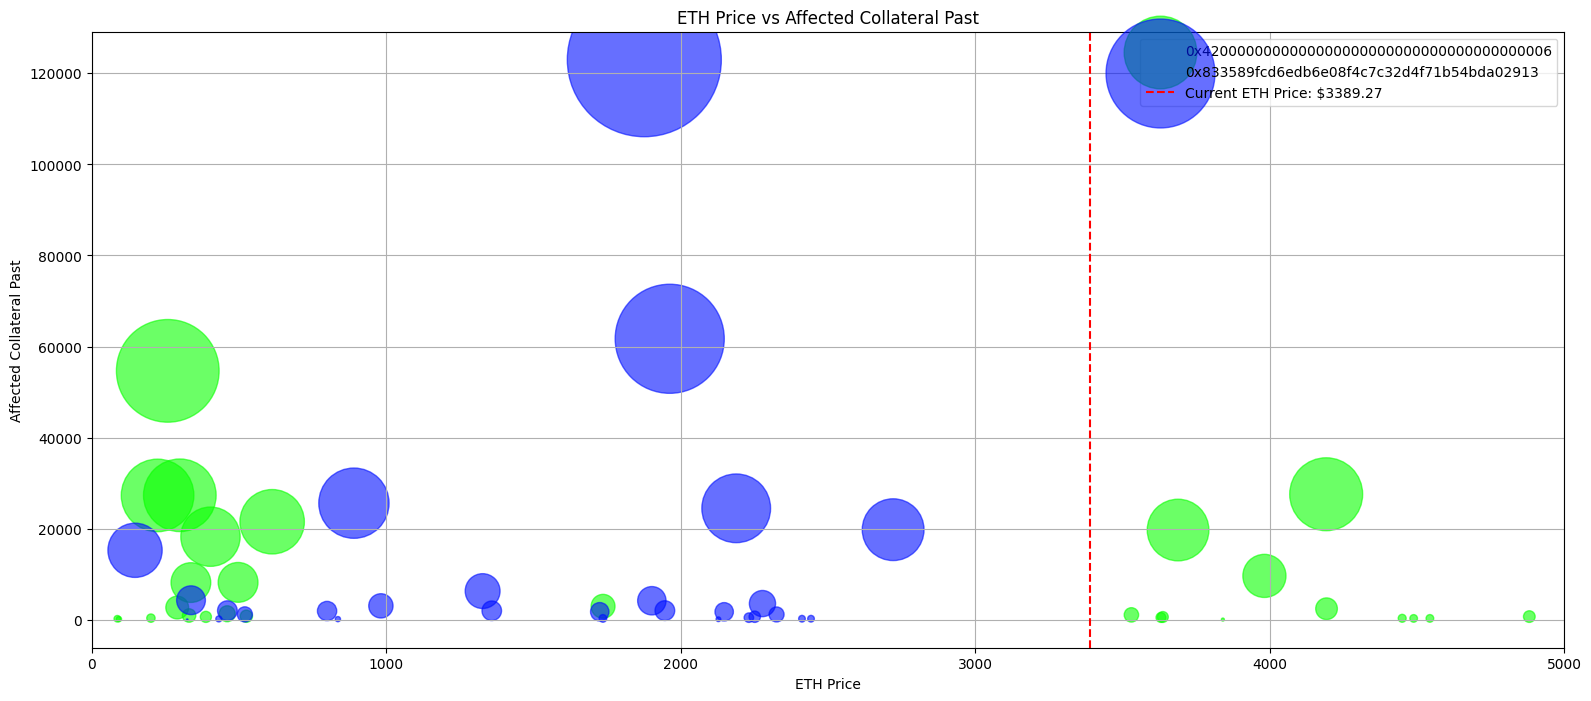

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the results DataFrame to only include rows where ETH Price is between 0 and 5000
results_df_filtered = results_df[(results_df['ETH Price'] > 0) & (results_df['ETH Price'] <= 5000)]

# Sort the filtered DataFrame by ETH Price
results_df_sorted = results_df_filtered.sort_values(by='ETH Price')

# Check the unique values in the Numeraire column
print("Unique Numeraires in the filtered data:", results_df_sorted['Numeraire'].unique())

# Define a colormap
palette = sns.color_palette("hsv", len(results_df_sorted['Numeraire'].unique()))

# Map each numeraire to a color
numeraire_color_map = {numeraire: color for numeraire, color in zip(results_df_sorted['Numeraire'].unique(), palette)}

# Plot ETH Price vs Affected Collateral Past as a scatter plot
plt.figure(figsize=(19, 8))

# Plot each numeraire with a different color
for numeraire in results_df_sorted['Numeraire'].unique():
    subset = results_df_sorted[results_df_sorted['Numeraire'] == numeraire]
    plt.scatter(subset['ETH Price'], subset['Affected Collateral Past'], 
                s=subset['Affected Collateral Past'] / 10,  # Adjust size scaling as needed
                color=numeraire_color_map[numeraire], alpha=0.6, label=numeraire)

# Point the current ETH price on the chart
current_eth_price = df_chainlink_prices.loc['0x4200000000000000000000000000000000000006', 'price']
plt.axvline(x=current_eth_price, color='red', linestyle='--', label=f'Current ETH Price: ${current_eth_price:.2f}')

plt.xlabel('ETH Price')
plt.ylabel('Affected Collateral Past')
plt.title('ETH Price vs Affected Collateral Past')
plt.legend(loc='upper right')  # Adjust legend location
plt.grid(True)
plt.xlim(0, 5000)  # Set the x-axis limit to display the range between 0 and 5000
plt.show()


In [21]:
from sympy import symbols, Eq, solve

# Define the unknown variable for USDC price
usdc_price_symbol = symbols('usdc_price')

# Initialize a DataFrame to store the results
usdc_results = []

# Iterate over each account in debtUsd_df where numeraire is USDC
for index, row in debtUsd_df.iterrows():
    numeraire = row['numeraire_normalized'].lower()
    if numeraire == '0x833589fcd6edb6e08f4c7c32d4f71b54bda02913':
        used_margin = row['usedMargin']
        position_distribution = {k.lower(): v for k, v in row['positionDistribution'].items()}
        position_distribution_usd_others = row['positionDistributionUsd'].get('others', 0)
        collateral_value_usd_past = row['collateralValueUsd']

        # Determine the decimal for the numeraire (USDC)
        numeraire_decimals = asset_decimals.get(numeraire, 6)

        # Calculate the left-hand side of the equation
        lhs = used_margin * usdc_price_symbol / (10 ** numeraire_decimals)

        # Calculate the right-hand side of the equation
        rhs = position_distribution_usd_others
        for asset, amount in position_distribution.items():
            liquidation_factor = liquidation_factors.get(asset, 1)
            decimals = asset_decimals.get(asset, 18)
            asset_price = df_chainlink_prices.loc[asset, 'price'] if asset in df_chainlink_prices.index else 0
            rhs += (amount * liquidation_factor * asset_price) / (10 ** decimals)

        # Solve the equation lhs = rhs for usdc_price_symbol
        equation = Eq(lhs, rhs)
        usdc_price_solution = solve(equation, usdc_price_symbol)

        # Store the result if a valid solution is found
        if usdc_price_solution:
            usdc_price = usdc_price_solution[0]

            # Calculate affected collateral using the found USDC price
            affected_collateral = position_distribution_usd_others
            for asset, amount in position_distribution.items():
                liquidation_factor = liquidation_factors.get(asset, 1)
                decimals = asset_decimals.get(asset, 18)
                asset_price = df_chainlink_prices.loc[asset, 'price'] if asset in df_chainlink_prices.index else 0
                affected_collateral += (amount * liquidation_factor * asset_price) / (10 ** decimals)

            usdc_results.append({
                'Account': row['account'],
                'Numeraire': numeraire,
                'Affected Collateral': affected_collateral,
                'Affected Collateral Past': collateral_value_usd_past,
                'USDC Price': usdc_price
            })

# Convert the results to a DataFrame
usdc_results_df = pd.DataFrame(usdc_results)

# Display the results
print(usdc_results_df)


                                       Account  \
0   0x362c2044c649ed82f68f7248ea653c0474f728ea   
1   0x3134f100cfee2b243a4e720a10fd072295c35c2b   
2   0xddc45afa54496da32ea8b70c9bb1eafb9ee531d4   
3   0xb5f55f017f1d5c33a383708b4d6f74ed27e70a0a   
4   0xe9483f9fc5f28bbebe1b94a8c8cb2e4a8afd4565   
..                                         ...   
66  0x820af2c2e54955894bc6d14335a77e31221f9215   
67  0xc720c7c569ac005441d210502d9df45d3bb3f278   
68  0xa3b83d6f653179453c456ea6ff8988470bdefdbf   
69  0x8e0937e6ff9c261d47947dfbffc845e03d9b6c8b   
70  0xbcb536082805d1f7a28a2a103535f44761f60767   

                                     Numeraire  Affected Collateral  \
0   0x833589fcd6edb6e08f4c7c32d4f71b54bda02913         22005.672267   
1   0x833589fcd6edb6e08f4c7c32d4f71b54bda02913          2586.901883   
2   0x833589fcd6edb6e08f4c7c32d4f71b54bda02913           140.035023   
3   0x833589fcd6edb6e08f4c7c32d4f71b54bda02913            31.454113   
4   0x833589fcd6edb6e08f4c7c32d4f71b54bda029

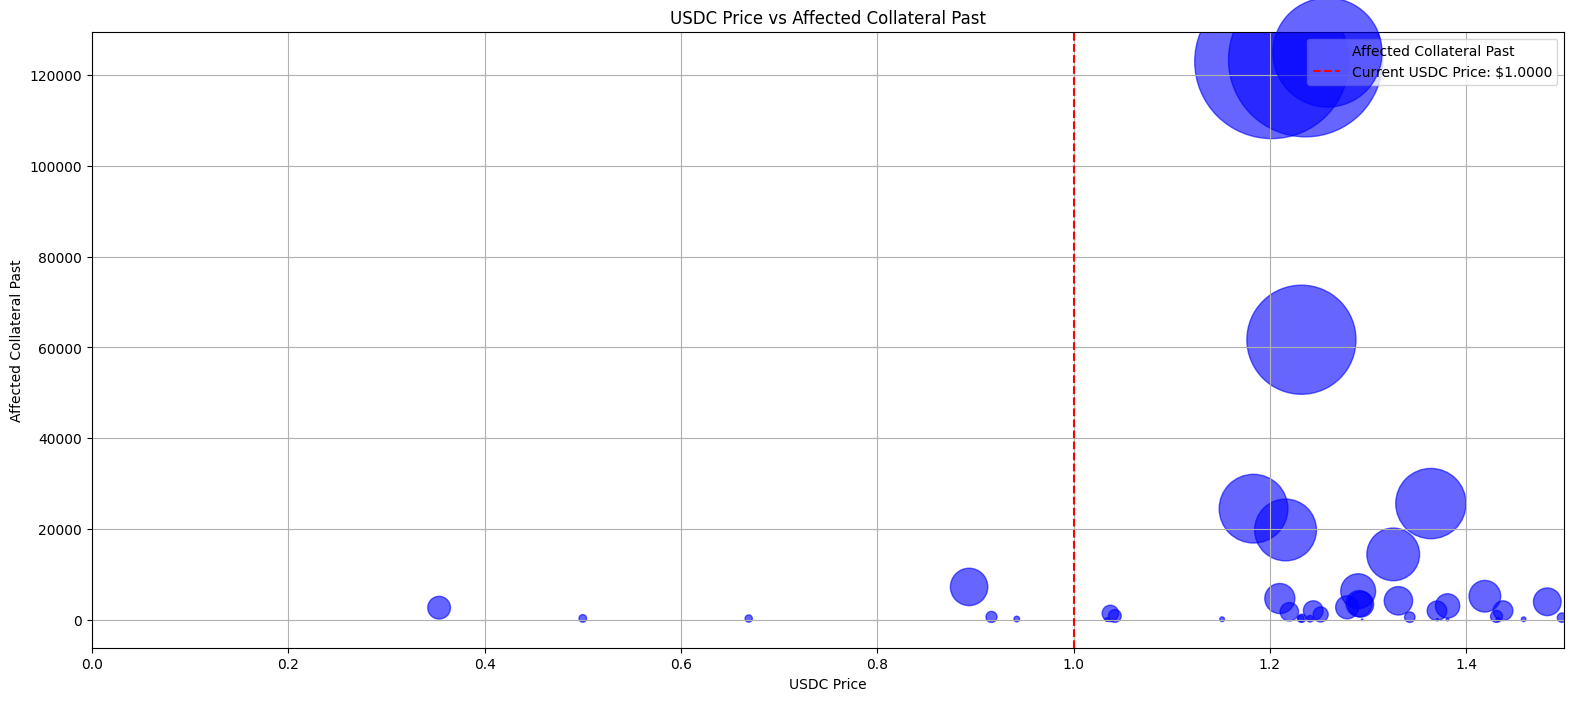

In [22]:
import matplotlib.pyplot as plt

# Filter the results DataFrame to only include rows where USDC Price is between 0 and 1.5
usdc_results_df_filtered = usdc_results_df[(usdc_results_df['USDC Price'] > 0) & (usdc_results_df['USDC Price'] <= 1.5)]

# Sort the filtered DataFrame by USDC Price
usdc_results_df_sorted = usdc_results_df_filtered.sort_values(by='USDC Price')

# Plot USDC Price vs Affected Collateral Past as a scatter plot
plt.figure(figsize=(19, 8))
plt.scatter(usdc_results_df_sorted['USDC Price'], usdc_results_df_sorted['Affected Collateral Past'], 
            s=usdc_results_df_sorted['Affected Collateral Past'] / 10,  # Adjust size scaling as needed
            label='Affected Collateral Past', color='blue', alpha=0.6)

# Point the current USDC price on the chart
current_usdc_price = df_chainlink_prices.loc['0x833589fcd6edb6e08f4c7c32d4f71b54bda02913', 'price']
plt.axvline(x=current_usdc_price, color='red', linestyle='--', label=f'Current USDC Price: ${current_usdc_price:.4f}')

plt.xlabel('USDC Price')
plt.ylabel('Affected Collateral Past')
plt.title('USDC Price vs Affected Collateral Past')
plt.legend(loc='upper right')  # Adjust legend location
plt.grid(True)
plt.xlim(0, 1.5)  # Set the x-axis limit to display the range between 0 and 1.5
plt.show()


Unique Numeraires in the filtered data: ['0x833589fcd6edb6e08f4c7c32d4f71b54bda02913']


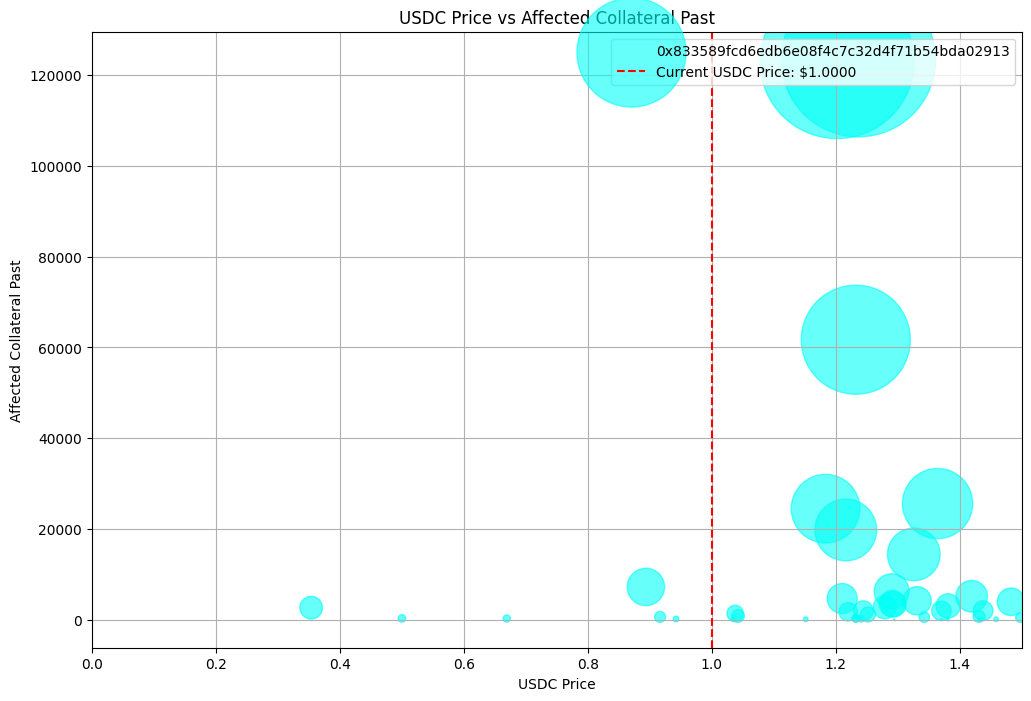

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the results DataFrame to only include rows where USDC Price is between 0 and 1.5
usdc_results_df_filtered = usdc_results_df[(usdc_results_df['USDC Price'] > 0) & (usdc_results_df['USDC Price'] <= 1.5)]

# Sort the filtered DataFrame by USDC Price
usdc_results_df_sorted = usdc_results_df_filtered.sort_values(by='USDC Price')

# Check the unique values in the Numeraire column
print("Unique Numeraires in the filtered data:", usdc_results_df_sorted['Numeraire'].unique())

# Define a colormap
palette = sns.color_palette("hsv", len(usdc_results_df_sorted['Numeraire'].unique()))

# Map each numeraire to a color
numeraire_color_map = {numeraire: color for numeraire, color in zip(usdc_results_df_sorted['Numeraire'].unique(), palette)}

# Plot USDC Price vs Affected Collateral Past as a scatter plot
plt.figure(figsize=(12, 8))

# Plot each numeraire with a different color
for numeraire in usdc_results_df_sorted['Numeraire'].unique():
    subset = usdc_results_df_sorted[usdc_results_df_sorted['Numeraire'] == numeraire]
    plt.scatter(subset['USDC Price'], subset['Affected Collateral Past'], 
                s=subset['Affected Collateral Past'] / 10,  # Adjust size scaling as needed
                color=numeraire_color_map[numeraire], alpha=0.6, label=numeraire)

# Point the current USDC price on the chart
current_usdc_price = df_chainlink_prices.loc['0x833589fcd6edb6e08f4c7c32d4f71b54bda02913', 'price']
plt.axvline(x=current_usdc_price, color='red', linestyle='--', label=f'Current USDC Price: ${current_usdc_price:.4f}')

plt.xlabel('USDC Price')
plt.ylabel('Affected Collateral Past')
plt.title('USDC Price vs Affected Collateral Past')
plt.legend(loc='upper right')  # Adjust legend location
plt.grid(True)
plt.xlim(0, 1.5)  # Set the x-axis limit to display the range between 0 and 1.5
plt.show()
